<center><h1><b> AICrowd Learning To Smell Challenge</b></h1></center>

<img src="https://d3000t1r8yrm6n.cloudfront.net/images/challenges/image_file/525/6a.jpg"/>

## What is the challenge exactly?

This challenge is all about the ability to be able to predict the different smells associate with a molecule. The information based upon which we are supposed to predict the smell is the smile of a molecule. Each molecule is labelled with multiple smells, with the total number of distinct smells being 109.

## What is a smile?

SMILES (Simplified Molecular Input Line Entry System) is a chemical notation that allows a user to represent a chemical structure in a way that can be used by the computer. They describe the structure of chemical species using short ASCII strings. 

## What is the most important task in this challenge?

This most important task at hand here is gaining a meaningful representation of each smile. There are several ways to do this, and this notebook attempts to give you quite a few pathways to gain a representation of a smile that can then be used in an ML pipeline. The different ways discussed here are:

- Tokenizing of Smiles and using ChemBERTA
- Graph Conv
- Molecular Fingerprints
- 2D representation of molecules (Chemception)


## Download the Data

In [ ]:
!gdown --id 1t5be8KLHOz3YuSmiiPQjopb4c_q2U4tG
!unzip olfactorydata.zip 
#thanks mmi333

Downloading...
From: https://drive.google.com/uc?id=1t5be8KLHOz3YuSmiiPQjopb4c_q2U4tG
To: /content/olfactorydata.zip
100% 94.3k/94.3k [00:00<00:00, 36.0MB/s]
Archive:  olfactorydata.zip
  inflating: train.csv               
  inflating: test.csv                
  inflating: sample_submission.csv   
  inflating: vocabulary.txt          


In [ ]:
!mkdir data
!mv train.csv data
!mv test.csv data
!mv vocabulary.txt data
!mv sample_submission.csv data

## Install reqd Libraries

In [ ]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)

def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))
install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [ ]:
!pip install -q transformers
!pip install -q simpletransformers
# !pip install wandb   #Uncomment if you want to use wandb

     |████████████████████████████████| 1.3MB 7.7MB/s 
     |████████████████████████████████| 2.9MB 54.7MB/s 
     |████████████████████████████████| 890kB 42.7MB/s 
     |████████████████████████████████| 1.1MB 42.4MB/s 
     |████████████████████████████████| 215kB 9.0MB/s 
     |████████████████████████████████| 1.7MB 17.7MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 7.4MB 55.7MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 317kB 51.5MB/s 
     |████████████████████████████████| 163kB 50.3MB/s 
     |████████████████████████████████| 122kB 56.3MB/s 
     |████████████████████████████████| 102kB 14.7MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 6.7MB 46.1MB/s 
     |████████████████████████████████| 112kB 59.9MB/s 
     |████████████████████████████████| 4.4MB 46.3MB/s 
     |████████████████████████████████| 133kB 54.8MB/

# ChemBerta

ChemBERTa ia a collection of BERT-like models applied to chemical SMILES data for drug design, chemical modelling, and property prediction. We finetune this existing model to use it for our application.

First we visualize the attention head using the bert-viz library, we can use this tool to see if the model infact understands the smiles it is processing.

We will be using the tokenizer that was pretrained, if we trained our own tokenizer the results would probably be better.

I plan on implementing this soon, but I have included a link in the References section of this notebook, if you want to have a crack at this.


In [ ]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [ ]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

Lets load the train data and have a look at a few molecules that have the same label and pass them to the pretrained roberta model(trained on the zinc 250k dataset).

In [ ]:
import pandas as pd
import numpy as np
train_df = pd.read_csv("data/train.csv")
train_df.head()

SMILES                   SENTENCE
0       C/C=C/C(=O)C1CCC(C=C1C)(C)C                fruity,rose
1                         COC(=O)OC      fresh,ethereal,fruity
2               Cc1cc2c([nH]1)cccc2          resinous,animalic
3            C1CCCCCCCC(=O)CCCCCCC1      powdery,musk,animalic
4  CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C  coniferous,camphor,fruity

In [ ]:
train_df.loc[train_df["SENTENCE"]=="resinous,animalic"]

SMILES           SENTENCE
2     Cc1cc2c([nH]1)cccc2  resinous,animalic
1108     Cc1nc2c(o1)cccc2  resinous,animalic
3183    Cc1ccc2c(n1)cccc2  resinous,animalic

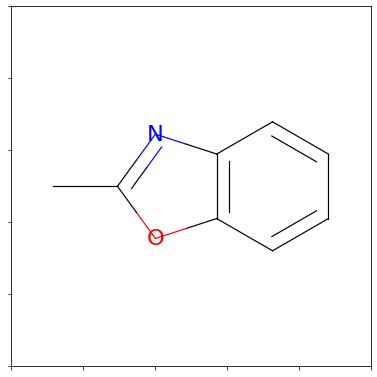

In [ ]:
import torch
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import rdFMCS
from matplotlib import colors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolToImage
m = Chem.MolFromSmiles('Cc1nc2c(o1)cccc2')
fig = Draw.MolToMPL(m, size=(200, 200))

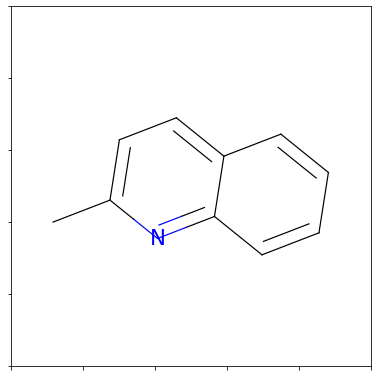

In [ ]:
m = Chem.MolFromSmiles('Cc1ccc2c(n1)cccc2')
fig = Draw.MolToMPL(m, size=(200,200))

In [ ]:
!git clone https://github.com/jessevig/bertviz.git

In [ ]:
import sys
sys.path.append("bertviz")

In [ ]:
from transformers import RobertaModel, RobertaTokenizer
from bertviz import head_view


model_version = 'seyonec/ChemBERTa_zinc250k_v2_40k'
model = RobertaModel.from_pretrained(model_version, output_attentions=True)
tokenizer = RobertaTokenizer.from_pretrained(model_version)

sentence_a = "Cc1cc2c([nH]1)cccc2"
sentence_b = "Cc1ccc2c(n1)cccc2"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

call_html()

head_view(attention, tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This is a pretty cool visualization of the attention head, please do explore the bert-viz library to have a look at some similar visualisation, i.e the model view and the nueron view!



### Now we finetune ChemBerta for our application!

For this we will be using the simple transformers library, ofcourse we might get better results if we do some hyperparameter tuning, but for a baseline let us assume the default params.

In [ ]:
from simpletransformers.classification import MultiLabelClassificationModel
import pandas as pd
import logging

# Uncomment for logging
# logging.basicConfig(level=logging.INFO)
# transformers_logger = logging.getLogger("transformers")
# transformers_logger.setLevel(logging.WARNING)

model = MultiLabelClassificationModel('roberta', 'seyonec/ChemBERTa_zinc250k_v2_40k',num_labels=109, args={'num_train_epochs': 10, 'auto_weights': True,'reprocess_input_data': True, 'overwrite_output_dir': True,'use_cuda':True,}) #'wandb_project': 'l2s'}) Use wandb if you want by uncommenting
# You can set class weights by using the optional weight argument

Some weights of the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k and are newly initi

In [ ]:
with open("/content/data/vocabulary.txt") as f:
  vocab = f.read().split('\n')

In [ ]:
def get_ohe_label(sentence):
  sentence = sentence.split(',')
  ohe_sent = len(vocab)*[0]
  for i,x in enumerate(vocab):
    if x in sentence:
      ohe_sent[i] = 1
  return ohe_sent

In [ ]:
labels = []
for x in train_df.SENTENCE.tolist():
  labels.append(get_ohe_label(x))
data_df = pd.DataFrame(train_df["SMILES"].tolist(),columns=["text"])# pd.DataFrame(labels,columns = vocab)
data_df["labels"]= labels


data_df.head()

text                                             labels
0       C/C=C/C(=O)C1CCC(C=C1C)(C)C  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1                         COC(=O)OC  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2               Cc1cc2c([nH]1)cccc2  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
3            C1CCCCCCCC(=O)CCCCCCC1  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
4  CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [ ]:
# Split the train and test dataset 80-20

train_size = 0.9
train_dataset=data_df.sample(frac=train_size,random_state=42).reset_index(drop=True)
test_dataset=data_df.drop(train_dataset.index).reset_index(drop=True)

In [ ]:
# check if our train and evaluation dataframes are setup properly. There should only be two columns for the SMILES string and its corresponding label.

print("FULL Dataset: {}".format(data_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (4316, 2)
TRAIN Dataset: (3884, 2)
TEST Dataset: (432, 2)


In [ ]:
# !wandb login  ## Log into wandb if you want to keep an eye on how your model is training

In [ ]:
!rm -rf outputs

### Time to Train!

In [ ]:
model.train_model(train_dataset)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f473bc74e48>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


(4860, 0.11029124964534501)

In [ ]:
import sklearn
result, model_outputs, wrong_predictions = model.eval_model(test_dataset)
print(result)
print(model_outputs)


{'LRAP': 0.48465526156536565, 'eval_loss': 0.0850957441661093}
[[0.00508118 0.00619125 0.01182556 ... 0.0051384  0.01132965 0.03271484]
 [0.0078125  0.00818634 0.05340576 ... 0.00867462 0.00963593 0.025177  ]
 [0.00346947 0.01490021 0.00288963 ... 0.00933838 0.006073   0.22290039]
 ...
 [0.00340271 0.01069641 0.00712204 ... 0.00698471 0.00468063 0.04803467]
 [0.00547028 0.0050621  0.01963806 ... 0.00720596 0.00772476 0.03271484]
 [0.00400543 0.02442932 0.00223351 ... 0.00769424 0.00413513 0.58496094]]


### Generate the test predictions

In [ ]:
test_df = pd.read_csv("/content/data/test.csv")
test_df.head()

SMILES
0    CCC(C)C(=O)OC1CC2CCC1(C)C2(C)C
1      CC(C)C1CCC(C)CC1OC(=O)CC(C)O
2   CC(=O)/C=C/C1=CCC[C@H](C1(C)C)C
3        CC(=O)OCC(COC(=O)C)OC(=O)C
4  CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)\C

In [ ]:
predictions, raw_outputs = model.predict(test_df["SMILES"].tolist())

In [ ]:
from tqdm.notebook import tqdm
final_preds=[]
for i,row in tqdm(test_df.iterrows(),total=len(test_df)):
    #predictions, raw_outputs = model.predict([row["SMILES"]])
    order = np.argsort(raw_outputs[i])[::-1][:15]
    labelled_preds = [vocab[i] for i in order]
    for x in labelled_preds:
      assert x in vocab
    sents = []
    for sent in range(0,15,3):
      sents.append(",".join([x for x in labelled_preds[sent:sent+3]]))
    pred = ";".join([x for x in sents])
    final_preds.append(pred)
print(len(final_preds),len(test_df))


1079 1079


In [ ]:
final = pd.DataFrame({"SMILES":test_df.SMILES.tolist(),"PREDICTIONS":final_preds})
final.head()

SMILES                                        PREDICTIONS
0    CCC(C)C(=O)OC1CC2CCC1(C)C2(C)C  camphor,resinous,fruity;woody,earthy,coniferou...
1      CC(C)C1CCC(C)CC1OC(=O)CC(C)O  fruity,sweet,mint;woody,herbal,green;spicy,van...
2   CC(=O)/C=C/C1=CCC[C@H](C1(C)C)C  woody,fruity,floral;herbal,resinous,fresh;bals...
3        CC(=O)OCC(COC(=O)C)OC(=O)C  fruity,apple,sweet;ethereal,fresh,burnt;herbal...
4  CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)\C  fruity,oily,fresh;floral,herbal,fatty;citrus,g...

In [ ]:
final.tail()

SMILES                                        PREDICTIONS
1074                                  CC(=CCCC(C)CC=O)C  citrus,floral,fresh;aldehydic,lemon,green;herb...
1075                              CC(=O)c1ccc(c(c1)OC)O  sweet,spicy,phenolic;floral,vanilla,woody;resi...
1076  C[C@@H]1CC[C@H]2[C@@H]1C1[C@H](C1(C)C)CC[C@]2(C)O  woody,camphor,earthy;herbal,resinous,musk;gree...
1077                         C=C1C=CCC(C)(C)C21CCC(C)O2  woody,floral,green;herbal,sweet,rose;balsamic,...
1078                                    CCC/C=C/C(OC)OC  fruity,green,herbal;apple,fresh,ethereal;sweet...

In [ ]:
final.to_csv("submission_chemberta.csv",index=False)


This gives a score of ~0.29 on the leaderboard.

# Using Graph Networks
[deepchem](https://github.com/deepchem/deepchem) is an amazing library that provides a high quality open-source toolchain that democratizes the use of deep-learning in drug discovery, materials science, quantum chemistry, and biology.

We will be using deepchem to make our GraphConvModel.
Molecules naturally lend themselves to being viewed as graphs. Graph Convolutions are one of the most powerful deep learning tools for working with molecular data.

Graph convolutions are similar to CNNs that are used to process images, but they operate on a graph. They begin with a data vector for each node of the graph (for example, the chemical properties of the atom that node represents). Convolutional and pooling layers combine information from connected nodes (for example, atoms that are bonded to each other) to produce a new data vector for each node.

In [ ]:
!pip install --pre deepchem

     |████████████████████████████████| 399kB 11.9MB/s 
  Created wheel for deepchem: filename=deepchem-2.4.0rc1.dev20201022163145-cp36-none-any.whl size=502778 sha256=15d5e46cda835e8b579932f827986f789ca962fbbcf9b853b043ca4961f84a1d
  Stored in directory: /root/.cache/pip/wheels/4b/ef/ce/c166ee776d4fcc0cd5e586887dcab72f9fc990b5b5f29fccea
Successfully built deepchem


The following code generated the top15 smells present in the dataset we will be using these smells to pad the results our model predicts, since the submission requires us to submit 5 sentences each of 3 smells each.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
def make_sentence_list(sent):
  return sent.split(",")
train_df = pd.read_csv("/content/data/train.csv")
train_df["SENTENCE_LIST"] = train_df.SENTENCE.apply(make_sentence_list)
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train_df.SENTENCE_LIST)
Y = multilabel_binarizer.transform(train_df.SENTENCE_LIST)
d = {}
for x,y in zip(multilabel_binarizer.classes_,Y.sum(axis=0)):
  d[x]=y

d = sorted(d.items(), key=lambda x: x[1], reverse=True)
top_15 = [x[0] for x in d[:20]]
top_15

['fruity',
 'floral',
 'woody',
 'herbal',
 'green',
 'fresh',
 'sweet',
 'resinous',
 'spicy',
 'balsamic',
 'rose',
 'earthy',
 'ethereal',
 'citrus',
 'oily',
 'mint',
 'tropicalfruit',
 'fatty',
 'nut',
 'camphor']

The GraphConvModel accepts the output of the ConvMolFeaturizer. To get the complete model cheatsheet click [here](https://github.com/deepchem/deepchem/blob/master/docs/models.rst). We thus preprocess our smiles using this Featurizer.

In [ ]:
import deepchem as dc
mols = [Chem.MolFromSmiles(smile) for smile in data_df["text"].tolist()]
feat = dc.feat.ConvMolFeaturizer()
arr = feat.featurize(mols)
print(arr.shape)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


(4316,)


In [ ]:
labels = []
train_df = pd.read_csv("data/train.csv")
for x in train_df.SENTENCE.tolist():
  labels.append(np.array(get_ohe_label(x)))
labels = np.array(labels)
print(labels.shape)

(4316, 109)


### Create a Train and Validation set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(arr,labels, test_size=.1, random_state=42)

In [ ]:
train_dataset = dc.data.NumpyDataset(X=X_train, y=y_train)
val_dataset = dc.data.NumpyDataset(X=X_test, y=y_test)

print(train_dataset)

<NumpyDataset X.shape: (3884,), y.shape: (3884, 109), w.shape: (3884, 1), task_names: [  0   1   2 ... 106 107 108]>


In [ ]:
print(val_dataset)

<NumpyDataset X.shape: (432,), y.shape: (432, 109), w.shape: (432, 1), ids: [0 1 2 ... 429 430 431], task_names: [  0   1   2 ... 106 107 108]>


In [ ]:
model = dc.models.GraphConvModel(n_tasks=109, mode='classification',dropout=0.2)
model.fit(train_dataset, nb_epoch=110)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.07197612126668294

The metric we will use to evaluate our model will be jaccard score, similar to the one used in the competition

In [ ]:
metric = dc.metrics.Metric(dc.metrics.jaccard_score)
print('training set score:', model.evaluate(train_dataset, [metric]))

training set score: {'jaccard_score': 0.3169358218239942}


The following is the auc roc score for each of the 109 classes.

In [ ]:
y_true = val_dataset.y
y_pred = model.predict(val_dataset)
metric = dc.metrics.roc_auc_score
for i in range(109):
  try:
    
    for gt,prediction in zip(y_true[:,i],y_pred[:,i]):
      assert round(prediction[0]+prediction[1])==1,prediction[0]-prediction[1]
    
    score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
    print(vocab[i], score)
  except:
     print("err")

alcoholic 0.9597902097902098
aldehydic 0.7968215994531784
alliaceous 0.9701421800947867
almond 0.980327868852459
ambergris 0.9151162790697674
ambery 0.8611374407582939
ambrette 0.9604651162790698
ammoniac 0.9930394431554523
animalic 0.7099206349206348
anisic 0.6938616938616939
apple 0.8399680255795363
balsamic 0.7959270984854967
banana 0.984375
berry 0.7504396482813749
blackcurrant 0.8998247663551402
err
body 0.8761682242990655
bread 0.9410046728971964
burnt 0.8518450523223793
butter 0.7444964871194379
cacao 0.9045667447306791
camphor 0.9093196314670446
caramellic 0.9230769230769231
cedar 0.732903981264637
cheese 0.8755668322176635
chemical 0.7866715623278868
cherry 0.9867909867909869
cinnamon 0.9945609945609946
citrus 0.8318850654617078
clean 0.7103174603174602
clove 0.6744366744366744
coconut 0.9970794392523364
coffee 0.9812646370023419
err
coniferous 0.9625292740046838
cooked 0.8358287365379564
cooling 0.6711492564714522
cucumber 0.994199535962877
dairy 0.812675448067372
dry 0.72380

Let's compare how the model does in comparision to the groundtruth.

**Note**: y_pred is of the shape (n_samples,n_tasks,n_classes) with y_pred[:,:,1] corresponding to the probabilities for class 1.

In [ ]:
y_true = val_dataset.y
y_pred = model.predict(val_dataset)
# print(y_true.shape,y_pred.shape)
for i in range(y_true.shape[0]):
  final_pred = []
  prob_val = []
  for y in range(109):
      prediction = y_pred[i,y]
      if prediction[1] > 0.37:
        final_pred.append(1)
        prob_val.append(prediction[1])
      else:
        final_pred.append(0)
  smell_ids = np.where(np.array(final_pred)==1)
  smells = [vocab[k] for k in smell_ids[0]]
  smells = [smells[k] for k in np.argsort(np.array(prob_val))] #to further order based on probability
  gt_smell_ids = np.where(np.array(y_true[i])==1)
  gt_smells = [vocab[k] for k in gt_smell_ids[0]]
  print(smells,gt_smells)


['sweet', 'resinous', 'cinnamon', 'berry', 'fruity', 'balsamic'] ['balsamic', 'cinnamon', 'fruity', 'powdery', 'sweet']
['spicy', 'woody'] ['dry', 'herbal']
['sweet', 'resinous', 'fruity', 'phenolic'] ['floral', 'fruity', 'resinous', 'sweet']
['herbal', 'ethereal', 'citrus', 'fresh', 'floral'] ['citrus', 'fresh', 'lily']
['green', 'waxy', 'tropicalfruit', 'butter', 'banana', 'fruity', 'cognac'] ['green', 'pear']
['fresh', 'floral'] ['geranium', 'leaf', 'spicy']
['resinous', 'fruity', 'geranium', 'rose', 'honey'] ['berry', 'geranium', 'honey', 'powdery', 'waxy']
['fermented', 'floral', 'balsamic', 'resinous', 'honey', 'rose'] ['floral', 'herbal', 'lemon', 'rose', 'spicy']
['waxy', 'seafood', 'musty', 'ammoniac', 'chemical', 'cognac', 'aldehydic', 'ethereal', 'pungent', 'oily', 'terpenic'] ['chemical']
['fresh', 'fermented', 'ester', 'ethereal', 'cognac', 'apple', 'banana', 'fruity'] ['apple', 'fermented']
['meat', 'dairy', 'cooked', 'vegetable', 'alliaceous', 'sulfuric'] ['alliaceous', 

###Generating test predictions

In [ ]:
test_df = pd.read_csv("/content/data/test.csv")
mols = [Chem.MolFromSmiles(smile) for smile in test_df["SMILES"].tolist()]
feat = dc.feat.ConvMolFeaturizer()#dc.feat.CircularFingerprint(size=1024)
test_arr = feat.featurize(mols)
print(test_arr.shape)

(1079,)


In [ ]:
test_dataset = dc.data.NumpyDataset(X=test_arr, y=np.zeros((len(test_df),109)))
print(test_dataset)

<NumpyDataset X.shape: (1079,), y.shape: (1079, 109), w.shape: (1079, 1), task_names: [  0   1   2 ... 106 107 108]>


In [ ]:
y_pred = model.predict(test_dataset)
top_5_preds=[]
c=0
# print(y_true.shape,y_pred.shape)
for i in range(y_pred.shape[0]):
  final_pred = []
  prob_val = []
  for y in range(109):
      prediction = y_pred[i,y]
      if prediction[1]>0.30:
        final_pred.append(1)
        prob_val.append(prediction[1])
      else:
        final_pred.append(0)
  smell_ids = np.where(np.array(final_pred)==1)
  smells = [vocab[k] for k in smell_ids[0]]
  #smells = [smells[k] for k in np.argsort(np.array(prob_val))] #to further order based on probability

  if len(smells)==0:
    c+=1
  if len(smells)>15:
      smells = smells[:15]
  else:
    new_smells = [x for x in top_15 if x not in smells]
    smells.extend(new_smells[:15-len(smells)])
  assert len(smells)==15
  sents = []
  for sent in range(0,15,3):
    sents.append(",".join([x for x in smells[sent:sent+3]]))
  pred = ";".join([x for x in sents])
  top_5_preds.append(pred)
  
print(len(top_5_preds))
print("[info] did not predict for ",c)

1079
[info] did not predict for  3


In [ ]:
final = pd.DataFrame({"SMILES":test_df.SMILES.tolist(),"PREDICTIONS":top_5_preds})
final.head()

SMILES                                        PREDICTIONS
0    CCC(C)C(=O)OC1CC2CCC1(C)C2(C)C  balsamic,camphor,cedar;coniferous,fruity,resin...
1      CC(C)C1CCC(C)CC1OC(=O)CC(C)O  cooling,fruity,mint;floral,woody,herbal;green,...
2   CC(=O)/C=C/C1=CCC[C@H](C1(C)C)C  berry,cedar,fruity;powdery,violetflower,woody;...
3        CC(=O)OCC(COC(=O)C)OC(=O)C  apple,banana,ester;fruity,odorless,floral;wood...
4  CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)\C  cognac,floral,fruity;geranium,rose,waxy;woody,...

In [ ]:
final.to_csv("submission_deepchem_graph_conv_0.3.csv",index=False)

This submission gives a score of 0.277 on the leaderboard.

# MultiTaskClassifier
Next we will use the MultiTaskClassifier of deepchem, with the featurizer CircularFingerprint.

The model accepts the following different featurizers.
- CircularFingerprint
- RDKitDescriptors
- CoulombMatrixEig
- RdkitGridFeaturizer
- BindingPocketFeaturizer
- ElementPropertyFingerprint

Feel free to substitute any one of these, and do report back your results and findings!

In [ ]:
mols = [Chem.MolFromSmiles(smile) for smile in data_df["text"].tolist()]
feat = dc.feat.CircularFingerprint(size=1024)
arr = feat.featurize(mols)
print(arr.shape)

(4316, 1024)


In [ ]:
labels = []
train_df = pd.read_csv("data/train.csv")
for x in train_df.SENTENCE.tolist():
  labels.append(np.array(get_ohe_label(x)))
labels = np.array(labels)
print(labels.shape)

(4316, 109)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(arr,labels, test_size=.1, random_state=42)

In [ ]:
train_dataset = dc.data.NumpyDataset(X=X_train, y=y_train)
val_dataset = dc.data.NumpyDataset(X=X_test, y=y_test)

print(train_dataset)

<NumpyDataset X.shape: (3884, 1024), y.shape: (3884, 109), w.shape: (3884, 1), task_names: [  0   1   2 ... 106 107 108]>


In [ ]:
print(val_dataset)

<NumpyDataset X.shape: (432, 1024), y.shape: (432, 109), w.shape: (432, 1), ids: [0 1 2 ... 429 430 431], task_names: [  0   1   2 ... 106 107 108]>


The MultitaskClassifier, is just a stack of dense layers. But that still leaves a lot of options. How many layers should there be, and how wide should each one be? What dropout rate should we use? What learning rate?

These are called hyperparameters. DeepChem provides a selection of hyperparameter optimization algorithms, which are found in the dc.hyper package. We use GridHyperparamOpt, which is the most basic method. We just give it a list of options for each hyperparameter and it exhaustively tries all combinations of them.

In [ ]:
import numpy as np
import numpy.random

params_dict = {'layer_sizes': [[500], [1000], [1000, 1000]],
              'dropouts': [0.2, 0.5],
              'learning_rate': [0.001, 0.0001] ,
              'n_tasks': [109],
               'n_features': [1024]
              } 



optimizer = dc.hyper.GridHyperparamOpt(dc.models.MultitaskClassifier)
metric = dc.metrics.Metric(dc.metrics.jaccard_score)
best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
        params_dict, train_dataset, val_dataset, [], metric)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We again evaluate the model based on jaccard score.

In [ ]:
metric = dc.metrics.Metric(dc.metrics.jaccard_score)
print('training set score:', best_model.evaluate(train_dataset, [metric]))

training set score: {'jaccard_score': 0.19314449838336573}


This seems to perform worse than the GraphConvModel that we made.

Lets look at the individual auc roc scores for each of the 109 classes.

In [ ]:
y_true = val_dataset.y
y_pred = best_model.predict(val_dataset)
metric = dc.metrics.roc_auc_score
for i in range(109):
  try:
    #print(y_true.shape,y_pred[:,i].shape)
    #print(y_true[:,i],y_pred[:,i])
    for gt,prediction in zip(y_true[:,i],y_pred[:,i]):
      assert round(prediction[0]+prediction[1])==1,prediction[0]-prediction[1]
    
    score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
    print(vocab[i], score)
  except:
     print("err")

alcoholic 0.8372183372183372
aldehydic 0.869958988380041
alliaceous 0.9765402843601896
almond 0.9185011709601874
ambergris 0.9686046511627906
ambery 0.9554502369668245
ambrette 0.8825581395348838
ammoniac 0.14849187935034802
animalic 0.7011904761904761
anisic 0.7451437451437453
apple 0.8836930455635492
balsamic 0.815435954479336
banana 0.9537146226415094
berry 0.8086330935251798
blackcurrant 0.8536799065420562
err
body 0.7429906542056075
bread 0.959696261682243
burnt 0.8098035615935377
butter 0.8072599531615925
cacao 0.8653395784543325
camphor 0.9113394755492559
caramellic 0.8869102258123738
cedar 0.8997658079625293
cheese 0.8958108399913625
chemical 0.8017257205801358
cherry 0.9898989898989898
cinnamon 0.9945609945609946
citrus 0.8515815085158152
clean 0.6396825396825397
clove 0.8461538461538461
coconut 0.9970794392523364
coffee 0.9896955503512881
err
coniferous 0.9414519906323184
cooked 0.9054373522458629
cooling 0.7304020561777125
cucumber 0.9918793503480279
dairy 0.8420427553444181

Lets compare the model predictions with the gt.

In [ ]:
y_true = val_dataset.y
y_pred = best_model.predict(val_dataset)
# print(y_true.shape,y_pred.shape)
for i in range(y_true.shape[0]):
  final_pred = []
  for y in range(109):
      prediction = y_pred[i,y]
      if prediction[1]>0.1:
        final_pred.append(1)
      else:
        final_pred.append(0)
  smell_ids = np.where(np.array(final_pred)==1)
  smells = [vocab[k] for k in smell_ids[0]]
  
  gt_smell_ids = np.where(np.array(y_true[i])==1)
  gt_smells = [vocab[k] for k in gt_smell_ids[0]]
  print(smells,gt_smells)
    
    

['balsamic', 'berry', 'fruity', 'spicy', 'sweet'] ['balsamic', 'cinnamon', 'fruity', 'powdery', 'sweet']
['mint', 'spicy', 'woody'] ['dry', 'herbal']
['floral', 'fresh', 'fruity', 'resinous', 'sweet'] ['floral', 'fruity', 'resinous', 'sweet']
['citrus', 'earthy', 'floral', 'fresh', 'herbal', 'pepper', 'rose', 'sweet', 'woody'] ['citrus', 'fresh', 'lily']
['butter', 'fruity', 'green', 'oily', 'tropicalfruit', 'waxy'] ['green', 'pear']
['dry', 'ethereal', 'floral', 'fresh', 'fruity', 'green', 'herbal', 'oily', 'sweet', 'woody'] ['geranium', 'leaf', 'spicy']
['balsamic', 'floral', 'fresh', 'fruity', 'geranium', 'honey', 'leaf', 'rose'] ['berry', 'geranium', 'honey', 'powdery', 'waxy']
['balsamic', 'floral', 'fresh', 'honey', 'oily', 'resinous', 'rose'] ['floral', 'herbal', 'lemon', 'rose', 'spicy']
['oily'] ['chemical']
['apple', 'banana', 'floral', 'fruity'] ['apple', 'fermented']
['alliaceous', 'cooked', 'earthy', 'fruity', 'sulfuric', 'tropicalfruit'] ['alliaceous', 'fresh', 'gourmand'

###Generating the test predictions

In [ ]:
test_df = pd.read_csv("/content/data/test.csv")
mols = [Chem.MolFromSmiles(smile) for smile in test_df["SMILES"].tolist()]
feat = dc.feat.CircularFingerprint(size=1024)
test_arr = feat.featurize(mols)
print(test_arr.shape)

(1079, 1024)


In [ ]:
test_dataset = dc.data.NumpyDataset(X=test_arr, y=np.zeros((len(test_df),109)))
print(test_dataset)

<NumpyDataset X.shape: (1079, 1024), y.shape: (1079, 109), w.shape: (1079, 1), task_names: [  0   1   2 ... 106 107 108]>


In [ ]:
y_pred = best_model.predict(test_dataset)
top_5_preds=[]
c=0
# print(y_true.shape,y_pred.shape)
for i in range(y_pred.shape[0]):
  final_pred = []
  for y in range(109):
      prediction = y_pred[i,y]
      if prediction[1]>0.30:
        final_pred.append(1)
      else:
        final_pred.append(0)
  smell_ids = np.where(np.array(final_pred)==1)
  smells = [vocab[k] for k in smell_ids[0]]
  if len(smells)==0:
    c+=1
  if len(smells)>15:
      smells = smells[:15]
  else:
    new_smells = [x for x in top_15 if x not in smells]
    smells.extend(new_smells[:15-len(smells)])
  assert len(smells)==15
  sents = []
  for sent in range(0,15,3):
    sents.append(",".join([x for x in smells[sent:sent+3]]))
  pred = ";".join([x for x in sents])
  top_5_preds.append(pred)
  
print(len(top_5_preds))
print("[info] did not predict for ",c)

1079
[info] did not predict for  182


In [ ]:
final = pd.DataFrame({"SMILES":test_df.SMILES.tolist(),"PREDICTIONS":top_5_preds})
final.head()

SMILES                                        PREDICTIONS
0    CCC(C)C(=O)OC1CC2CCC1(C)C2(C)C  camphor,resinous,woody;fruity,floral,herbal;gr...
1      CC(C)C1CCC(C)CC1OC(=O)CC(C)O  cooling,fruity,floral;woody,herbal,green;fresh...
2   CC(=O)/C=C/C1=CCC[C@H](C1(C)C)C  fresh,fruity,floral;woody,herbal,green;sweet,r...
3        CC(=O)OCC(COC(=O)C)OC(=O)C  fruity,floral,woody;herbal,green,fresh;sweet,r...
4  CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)\C  fruity,rose,floral;woody,herbal,green;fresh,sw...

In [ ]:
final.to_csv("submission_deepchem_circular_fingerprint_0.3.csv",index=False)

This submission gives a score of ~0.253 on the leaderboard.

#Using skmultilearn

We can also use the molecular fingerprints as inputs to class ML Algos like Random Forest, LabelPowerSet set a try.

We can use any models available in sklearn for multiclass problem, but I have just used these two to demonstrate a possible attempt at using sklearn.

In [ ]:
!pip install -q scikit-multilearn --upgrade

     |████████████████████████████████| 92kB 7.4MB/s 


This function should approximate the evaluation metric used in the challenge.

In [ ]:
def in_top_5(top_5_sents,target):
  ll = top_5_sents.split(";")
  max_scr = 0 
  for x in ll:
    smells = x.split(',')
    c = 0 
    for y in target.split(','):
      if y in smells:
        c+=1
    scr = c/(len(target.split(','))+len(smells)-c)
    if scr>max_scr:
      max_scr = scr

  return max_scr

In [ ]:
def get_submission(y_pred,labels = vocab):
  top_5_preds = []
  for i in range(y_pred.shape[0]):
    smell_ids = np.where(y_pred[i]==1)
    smells = [labels[k] for k in smell_ids[0]]
    if len(smells)>15:
      smells = smells[:15]
    else:
     new_smells = [x for x in top_15 if x not in smells]
     smells.extend(new_smells[:15-len(smells)])
    sents = []
    for sent in range(0,15,3):
      sents.append(",".join([x for x in smells[sent:sent+3]]))
    pred = ";".join([x for x in sents])
    top_5_preds.append(pred)
  return top_5_preds

In [ ]:
mols = [Chem.MolFromSmiles(smile) for smile in data_df["text"].tolist()]
feat = dc.feat.CircularFingerprint(size=1024)
arr = feat.featurize(mols)
print(arr.shape)

(4316, 1024)


In [ ]:
labels = []
train_df = pd.read_csv("data/train.csv")
for x in train_df.SENTENCE.tolist():
  labels.append(np.array(get_ohe_label(x)))
labels = np.array(labels)
print(labels.shape)

(4316, 109)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(arr,labels, test_size=.1, random_state=42)

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
import time

start=time.time()
classifier = BinaryRelevance(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)

classifier.fit(X_train, y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')

training time taken:  87.0 seconds


In [ ]:
start=time.time()
predictions=classifier.predict(X_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')
top_5_predictions = get_submission(predictions.toarray())

prediction time taken:  2.0 seconds


In [ ]:
gt = []
for i in range(y_test.shape[0]):
    smell_ids = np.where(y_test[i]==1)
    smells = [vocab[k] for k in smell_ids[0]]
    gt.append(",".join([x for x in smells[:min(len(smells),3)]])) 
val_dict = {"top_5_sents":top_5_predictions,"target":gt}
df_to_eval = pd.DataFrame(val_dict)
top_5_scr = []
for pred,y in zip(df_to_eval.top_5_sents.tolist(),df_to_eval.target.tolist()):
  top_5_scr.append(in_top_5(pred,y))
df_to_eval["top_5_score"] = top_5_scr
print("OVERALL SCORE:",np.mean(df_to_eval.top_5_score.tolist()))
display(df_to_eval.head())

OVERALL SCORE: 0.240625


top_5_sents  ... top_5_score
0  balsamic,fruity,floral;woody,herbal,green;fres...  ...        0.50
1  fruity,floral,woody;herbal,green,fresh;sweet,r...  ...        0.25
2  resinous,fruity,floral;woody,herbal,green;fres...  ...        1.00
3  citrus,fresh,lily;rose,fruity,floral;woody,her...  ...        1.00
4  balsamic,fatty,fruity;green,sweet,tropicalfrui...  ...        0.25

[5 rows x 3 columns]

###Generating Test Predictions

In [ ]:
test_df = pd.read_csv("/content/data/test.csv")
mols = [Chem.MolFromSmiles(smile) for smile in test_df["SMILES"].tolist()]
feat = dc.feat.CircularFingerprint(size=1024)
test_arr = feat.featurize(mols)
print(test_arr.shape)

(1079, 1024)


In [ ]:
start=time.time()
predictions=classifier.predict(test_arr)
print('prediction time taken: ',round(time.time()-start,0),'seconds')
top_5_predictions = get_submission(predictions.toarray())

prediction time taken:  3.0 seconds


In [ ]:
final = pd.DataFrame({"SMILES":test_df.SMILES.tolist(),"PREDICTIONS":top_5_predictions})
final.head()

SMILES                                        PREDICTIONS
0    CCC(C)C(=O)OC1CC2CCC1(C)C2(C)C  camphor,resinous,fruity;floral,woody,herbal;gr...
1      CC(C)C1CCC(C)CC1OC(=O)CC(C)O  fruity,floral,woody;herbal,green,fresh;sweet,r...
2   CC(=O)/C=C/C1=CCC[C@H](C1(C)C)C  fruity,floral,woody;herbal,green,fresh;sweet,r...
3        CC(=O)OCC(COC(=O)C)OC(=O)C  odorless,fruity,floral;woody,herbal,green;fres...
4  CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)\C  cognac,floral,fruity;woody,herbal,green;fresh,...

In [ ]:
final.to_csv("submission_deepchem_sklearn_rf.csv",index=False)

This submission gives a score of ~0.24 on the leaderboard.

### Label PowerSet

It is a problem transformation approach to multi-label classification that transforms a multi-label problem to a multi-class problem with 1 multi-class classifier trained on all unique label combinations found in the training data.

In [ ]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB

# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)


top_5_predictions = get_submission(predictions.toarray())
gt = []
for i in range(y_test.shape[0]):
    smell_ids = np.where(y_test[i]==1)
    smells = [vocab[k] for k in smell_ids[0]]
    gt.append(",".join([x for x in smells[:min(len(smells),3)]])) 
val_dict = {"top_5_sents":top_5_predictions,"target":gt}
df_to_eval = pd.DataFrame(val_dict)
top_5_scr = []
for pred,y in zip(df_to_eval.top_5_sents.tolist(),df_to_eval.target.tolist()):
  top_5_scr.append(in_top_5(pred,y))
df_to_eval["top_5_score"] = top_5_scr
print("OVERALL SCORE:",np.mean(df_to_eval.top_5_score.tolist()))
display(df_to_eval.head())

OVERALL SCORE: 0.23996913580246917


top_5_sents  ... top_5_score
0  balsamic,fruity,floral;woody,herbal,green;fres...  ...        0.50
1  spicy,fruity,floral;woody,herbal,green;fresh,s...  ...        0.25
2  odorless,fruity,floral;woody,herbal,green;fres...  ...        0.50
3  citrus,fresh,lily;rose,fruity,floral;woody,her...  ...        1.00
4  balsamic,fatty,fruity;green,sweet,tropicalfrui...  ...        0.25

[5 rows x 3 columns]

###Generating Test Predictions

In [ ]:
start=time.time()
predictions=classifier.predict(test_arr)
print('prediction time taken: ',round(time.time()-start,0),'seconds')
top_5_predictions = get_submission(predictions.toarray())

prediction time taken:  10.0 seconds


In [ ]:
final = pd.DataFrame({"SMILES":test_df.SMILES.tolist(),"PREDICTIONS":top_5_predictions})
final.head()

SMILES                                        PREDICTIONS
0    CCC(C)C(=O)OC1CC2CCC1(C)C2(C)C  balsamic,resinous,fruity;floral,woody,herbal;g...
1      CC(C)C1CCC(C)CC1OC(=O)CC(C)O  mint,fruity,floral;woody,herbal,green;fresh,sw...
2   CC(=O)/C=C/C1=CCC[C@H](C1(C)C)C  odorless,fruity,floral;woody,herbal,green;fres...
3        CC(=O)OCC(COC(=O)C)OC(=O)C  odorless,fruity,floral;woody,herbal,green;fres...
4  CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)\C  cognac,floral,fruity;woody,herbal,green;fresh,...

In [ ]:
final.to_csv("submission_deepchem_sklearn_powerlabelledset.csv",index=False)

This submission gives a score of ~0.26 on the leaderboard.

# Chemception


Chemception is named after the Inception modules which will be used for the neural network. This method is based on this [paper](https://arxiv.org/ftp/arxiv/papers/1706/1706.06689.pdf). The Smiles are encoded as 2D images. 


In [ ]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
print("RDKit: %s"%rdkit.__version__)

RDKit: 2020.09.1


###Preprocessing the Data

The first step is to encode the molecule into an “image”.

The function below takes an RDKit mol and encodes the molecular graph as an image with 4 channels.

After reading in the molecule the Gasteiger charges are calculated and the 2D drawing coordinates computed. They are usually computed before generating depictions of the molecule, but we are goind to need them “raw”, so they are extracted to the coords matrix.

The vect matrix is defined and filled with zeros (vacuum) and is of the shape (image_width, image_height,4). Each layer is then used to encode different information from the molecule.

Layer zero is filled with information about the bonds and encoded the bondorder.
The next three layers are encoded with the atomic number, Gasteiger charges and hybridization.

More features can lead to the creation of more channels. But infact for right now we use only the first 3 channels to input into any CNN of our choice. 

I am working on the implementation that will use the Inception model mentioned in the original paper, that takes into account all 4 channels so stay tuned!

In [ ]:
import pandas as pd 
import numpy as np

embed = 20 
res = 0.5 
train = pd.read_csv("data/train.csv")
display(train.head())

SMILES                   SENTENCE
0       C/C=C/C(=O)C1CCC(C=C1C)(C)C                fruity,rose
1                         COC(=O)OC      fresh,ethereal,fruity
2               Cc1cc2c([nH]1)cccc2          resinous,animalic
3            C1CCCCCCCC(=O)CCCCCCC1      powdery,musk,animalic
4  CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C  coniferous,camphor,fruity

In [ ]:
from rdkit import Chem 
train["mol"] = train["SMILES"].apply(Chem.MolFromSmiles)

In [ ]:
mol = train["mol"][1]
dims = int(embed*2/res)
cmol = Chem.Mol(mol.ToBinary())
cmol.ComputeGasteigerCharges()

In [ ]:
def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
    return vect
    
data = pd.read_csv("data/train.csv")
data["mol"] = data["SMILES"].apply(Chem.MolFromSmiles)

Lets try to “chemcepterize” a molecule and show it as an image. Matplotlib only supports RGB, so only the first three channels are used.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(72, 72, 4)


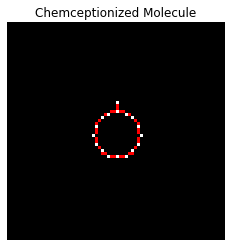

In [ ]:
mol = data["mol"][3]
v = chemcepterize_mol(mol, embed=18, res=0.5)
print(v.shape)
plt.imshow(v[:,:,:3])
plt.axis('off')
plt.title("Chemceptionized Molecule")
plt.show()

Some molecules are really long and its difficult to embed them into such a small image, so we drop these molecules from our dataset.

In [ ]:
chemcepterize_mols = []
idxs_to_drop = []
for i,mol in enumerate(data["mol"].tolist()):
  try:
    chemcepterize_mols.append(chemcepterize_mol(mol, embed=16, res=0.5))
  except:
    print(i,mol,data.iloc[i]["SMILES"],len(data.iloc[i]["SMILES"]))
    idxs_to_drop.append(i)
data.drop(idxs_to_drop,inplace=True)
data.reset_index(inplace=True,drop=True)

142 <rdkit.Chem.rdchem.Mol object at 0x7f45c1976030> CC1CCc2c(C1)occ2C.CC1CCC(C(C1)OC(=O)C)C(C)C.CC1CCC(=C(C)C)C(=O)C1.CC1CCC(C(=O)C1)C(C)C.CC1CCC(C(C1)O)C(C)C.CC1CCC2(CC1)OCC2C 124
195 <rdkit.Chem.rdchem.Mol object at 0x7f45c1993120> CCCCCCC(C/C=C\CCCCCCCC(=O)OC(COC(=O)CCCCCCC/C=C\CC(CCCCCC)O)COC(=O)CCCCCCC/C=C\CC(CCCCCC)O)O 92
248 <rdkit.Chem.rdchem.Mol object at 0x7f45c196f210> OC1C[C@H]2C([C@]1(C)CC2)(C)C.C=CC(CCC=C(C)C)C.C=CCc1ccc(c(c1)OC)OC.OC/C=C(\CCC=C(C)C)/C.O=C/C=C(\CCC=C(C)C)/C 109
2318 <rdkit.Chem.rdchem.Mol object at 0x7f4606823850> Cn1cnc2c1c(=O)n(C)c(=O)n2C.Cn1cnc2c1c(=O)[nH]c(=O)n2C.Oc1cc2OC(c3ccc(c(c3)O)O)C(Cc2c(c1)O)O 91
2716 <rdkit.Chem.rdchem.Mol object at 0x7f46068247b0> C/C(=C\C=C\C=C(\C=C\C=C(\C=C\C1=C(C)C[C@H](CC1(C)C)O)/C)/C)/C=C/C=C(/C=C/C(=O)[C@]1(C)C[C@H](CC1(C)C)O)\C 105
2880 <rdkit.Chem.rdchem.Mol object at 0x7f4606832c10> CC(=O)CCC/C=C/C=C/C=C.CC(=O)CCC/C=C\C=C\C=C.CCC(=O)CC/C=C/C=C/C=C.CCC(=O)CC/C=C\C=C\C=C.CCCC(=O)C/C=C/C=C/C=C.CCCC(=O)C/C=C\C=C\C=C 131

### Data Augmentation, Let's Double the dataset!

A smile is not a unique way to represent a molecule so we use rdkit to create different versions of the same smile and add them to our dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'C1CCCC(=O)CCCCCCCCCCC1', 'C1CCCCCCCCCCC(=O)CCCC1', 'C1C(=O)CCCCCCCCCCCCCC1', 'C1CCCCCCCCCCCCCC(=O)C1', 'C1CCC(=O)CCCCCCCCCCCC1', 'C1CCCCCCCCCCCCCCC1=O', 'O=C1CCCCCCCCCCCCCCC1', 'C1CC(=O)CCCCCCCCCCCCC1', 'C1CCCCCC(=O)CCCCCCCCC1', 'C1CCCCC(=O)CCCCCCCCCC1', 'C1CCCCCCCCCC(=O)CCCCC1', 'C1(=O)CCCCCCCCCCCCCCC1', 'C1CCCCCCCCCCCCC(=O)CC1', 'C1CCCCCCCCCCCC(=O)CCC1', 'C1CCCCCCC(=O)CCCCCCCC1', 'C1CCCCCCCC(=O)CCCCCCC1', 'C1CCCCCCCCC(=O)CCCCCC1'}
17


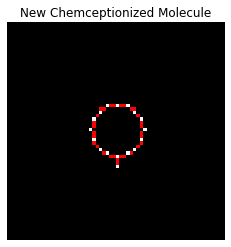

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


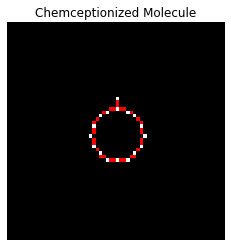

In [ ]:
import random

def randomSmiles(m1):
    m1.SetProp("_canonicalRankingNumbers", "True")
    idxs = list(range(0,m1.GetNumAtoms()))
    random.shuffle(idxs)
    for i,v in enumerate(idxs):
        m1.GetAtomWithIdx(i).SetProp("_canonicalRankingNumber", str(v))
    return Chem.MolToSmiles(m1)

m1 = Chem.MolFromSmiles(data["SMILES"][3])
v1 = chemcepterize_mol(m1, embed=16, res=0.5)
s = set()
for i in range(1000):
  smiles = randomSmiles(m1)
  s.add(smiles)

print(s)
print(len(s))

for new_mol in s:
  mol = Chem.MolFromSmiles(new_mol)
  v = chemcepterize_mol(mol, embed=16, res=0.5)
  #print(v.shape,v1.shape)
  diff = (v1-v).astype(np.int)
  if len(np.unique(diff)) > 4:
    plt.imshow(v[:,:,:3])
    plt.axis('off')
    plt.title("New Chemceptionized Molecule")
    plt.show()

    plt.imshow(v1[:,:,:3])
    plt.axis('off')
    plt.title("Chemceptionized Molecule")
    plt.show()
    break


Process and save the entire train set

In [ ]:
from tqdm.notebook import tqdm
new_smiles = []
new_labels = []
did_not_add = 0
for smile,label in tqdm(zip(data["SMILES"].tolist(),data["SENTENCE"].tolist()),total = len(data)):
    m1 = Chem.MolFromSmiles(smile)
    v1 = chemcepterize_mol(m1, embed=16, res=0.5)
    s = set()
    flag = 0 
    for i in range(1000):
      smiles = randomSmiles(m1)
      s.add(smiles)

    for new_mol in s:
      mol = Chem.MolFromSmiles(new_mol)
      try:
           v = chemcepterize_mol(mol, embed=16, res=0.5)
      except:
           continue
      diff = (v1-v).astype(np.int)
      if len(np.unique(diff)) > 4:
        flag=1
        new_smiles.append(new_mol)
        new_labels.append(label)
        break
    if flag == 0:
      did_not_add+=1
print("[INFO] Did not add for",did_not_add,"/",len(data),"i.e",did_not_add/len(data)*100,"%")


[INFO] Did not add for 382 / 4309 i.e 8.865165931770711 %


In [ ]:
len(new_smiles),len(new_labels)

(3927, 3927)

In [ ]:
orig_smiles = data["SMILES"].tolist()
orig_labels = data["SENTENCE"].tolist()
orig_smiles.extend(new_smiles)
orig_labels.extend(new_labels)

In [ ]:
filenames = [str(x)+".png" for x in range(len(orig_smiles))]

In [ ]:
new_data = pd.DataFrame({"SMILES":orig_smiles,"SENTENCE":orig_labels,"FILENAME":filenames})
new_data["mol"] = new_data["SMILES"].apply(Chem.MolFromSmiles)

In [ ]:
new_data.head()

SMILES  ...                                               mol
0       C/C=C/C(=O)C1CCC(C=C1C)(C)C  ...  <rdkit.Chem.rdchem.Mol object at 0x7f4606622f30>
1                         COC(=O)OC  ...  <rdkit.Chem.rdchem.Mol object at 0x7f4606622440>
2               Cc1cc2c([nH]1)cccc2  ...  <rdkit.Chem.rdchem.Mol object at 0x7f4606622760>
3            C1CCCCCCCC(=O)CCCCCCC1  ...  <rdkit.Chem.rdchem.Mol object at 0x7f46066224e0>
4  CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C  ...  <rdkit.Chem.rdchem.Mol object at 0x7f46066220d0>

[5 rows x 4 columns]

In [ ]:
!mkdir chemception_data
!mkdir chemception_data/train
!mkdir chemception_data/test

In [ ]:
import PIL
def save_png(mol,filename,mode):
    v = chemcepterize_mol(mol, embed=16,res=0.5)
    PIL.Image.fromarray((v[:,:,:3]*255).astype(np.uint8)).save("chemception_data/"+mode+"/"+filename)
  
for i,r in new_data.iterrows():
  save_png(Chem.MolFromSmiles(r["SMILES"]),r["FILENAME"],"train")

Process and save the entire test set



In [ ]:
test = pd.read_csv("data/test.csv")
test["mol"] = test["SMILES"].apply(Chem.MolFromSmiles)
test_filenames = [str(x)+".png" for x in range(len(test))]
test["FILENAME"] = test_filenames
test.head()

SMILES  ... FILENAME
0    CCC(C)C(=O)OC1CC2CCC1(C)C2(C)C  ...    0.png
1      CC(C)C1CCC(C)CC1OC(=O)CC(C)O  ...    1.png
2   CC(=O)/C=C/C1=CCC[C@H](C1(C)C)C  ...    2.png
3        CC(=O)OCC(COC(=O)C)OC(=O)C  ...    3.png
4  CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)\C  ...    4.png

[5 rows x 3 columns]

In [ ]:
chemcepterize_mols = []
idxs_to_drop = []
for i,mol in enumerate(test["mol"].tolist()):
  try:
    chemcepterize_mols.append(chemcepterize_mol(mol, embed=16, res=0.5))
  except:
    print(i,mol,test.iloc[i]["SMILES"],len(test.iloc[i]["SMILES"]))
    idxs_to_drop.append(i)
test.drop(idxs_to_drop,inplace=True)
test.reset_index(inplace=True,drop=True)

405 <rdkit.Chem.rdchem.Mol object at 0x7f460a87d5d0> CCCCCCCCCCCCOC(=O)CCC(=O)OCCCCCCCCCCCC 38
470 <rdkit.Chem.rdchem.Mol object at 0x7f460a87ea80> CCCCCCCCCc1ccc(cc1)OP(Oc1ccc(cc1)CCCCCCCCC)Oc1ccc(cc1)CCCCCCCCC 63
755 <rdkit.Chem.rdchem.Mol object at 0x7f460a8845d0> CC(=CCC/C(=C/C=C/C(=C/C=C/C(=C/C=C/C=C(\C)/C=C/C=C(\C)/C=C/C=C(\C)/CCC=C(C)C)/C)/C)/C)C 87


In [ ]:
for i,r in test.iterrows():
  save_png(r["mol"],r["FILENAME"],"test")

In [ ]:
new_data.to_csv("chemception_data/new_data.csv",index=False)
test.to_csv("chemception_data/test_data.csv",index=False)

### Using Fastai and first 3 channels of Chemceptionized Molecule as Input

In [ ]:
import sys
import os
import gc
import warnings
import torch

import torch.nn as nn
import numpy as np
import pandas as pd 
import torch.nn.functional as F

from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from tqdm.notebook import tqdm

In [ ]:
np.random.seed(42) # set random seed so we always get the same validation set
src =  (ImageList.from_df(path="/content/chemception_data/train", df=new_data, cols=["FILENAME"]).split_by_rand_pct(0.2).label_from_df(label_delim=',').databunch(num_workers=0,bs=64)).normalize(imagenet_stats)    
    

Let's visualize the data

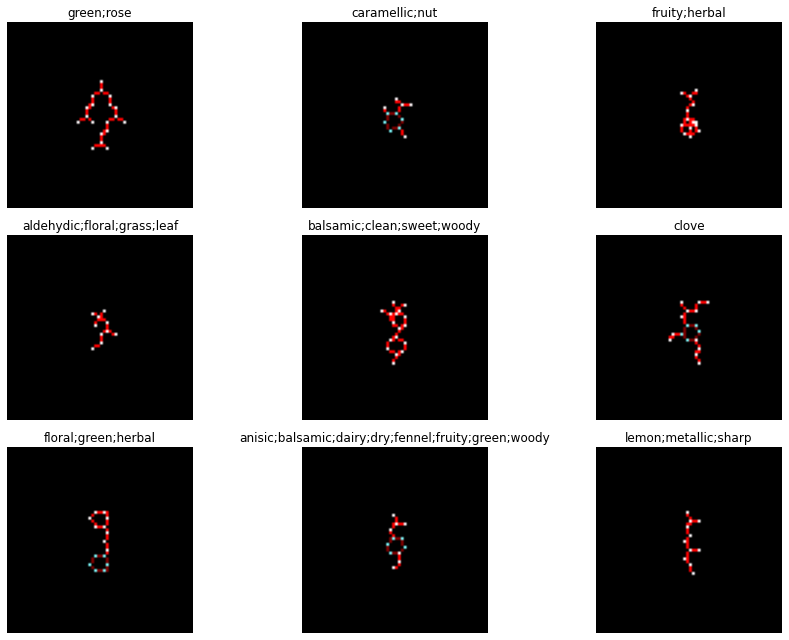

In [ ]:
src.show_batch(rows=3, figsize=(12, 9))

Defining the model, feel free to switch to any cnn, I am using vgg19.

In [ ]:
# create metrics
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
# create cnn with the resnet50 architecture
learn = cnn_learner(src, models.vgg19_bn, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


Find optimal Learning Rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


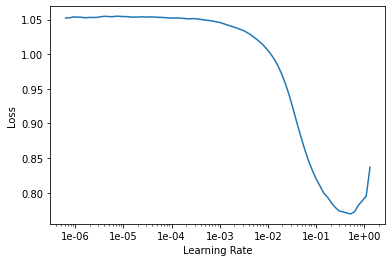

In [ ]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate

Stage 1 Training

In [ ]:
lr = 0.001 # chosen learning rate
learn.fit_one_cycle(4, lr) # train model for 4 epochs

learn.save('chemception-stage-1') # save model

Unfreeze the model and find new optimal lr.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


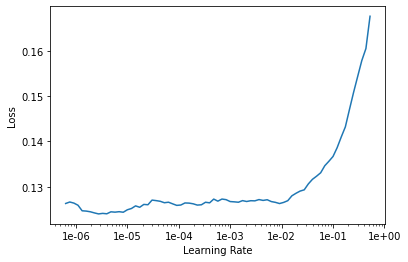

In [ ]:
learn.unfreeze() # unfreeze all layers

learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate


Stage 2 Training

In [ ]:
learn.fit_one_cycle(15, slice(1e-5, lr/5)) # fit model with differential learning rates

learn.save('chemception-stage-2') # save model

Export the model for future use

In [ ]:
learn.export()

Let's see how the model performs on the Val set

In [ ]:
val_fns = [str(x) for x in learn.data.valid_ds.items]

In [ ]:
val_fns_y=[str(x) for x in learn.data.valid_ds.y]

In [ ]:
for img,gt in zip(val_fns,val_fns_y):
  pred_class, pred_idx, preds=learn.predict(open_image(img))
  print("----------------------------------------------------------")
  thresh = 0.1
  labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(preds) if p > thresh])]
  print("GT:",gt)
  print("PREDS:",labelled_preds)
  print("----------------------------------------------------------")


Streaming output truncated to the last 5000 lines.
GT: fresh;camphor
PREDS: ['camphor coniferous fresh resinous']
----------------------------------------------------------
----------------------------------------------------------
GT: green;green;resinous
PREDS: ['floral fruity green herbal resinous sweet']
----------------------------------------------------------
----------------------------------------------------------
GT: floral;vanilla
PREDS: ['floral nut phenolic spicy sweet vanilla']
----------------------------------------------------------
----------------------------------------------------------
GT: fresh;rose
PREDS: ['nut phenolic spicy sweet']
----------------------------------------------------------
----------------------------------------------------------
GT: floral;spicy;balsamic
PREDS: ['balsamic floral fruity green herbal resinous sweet']
----------------------------------------------------------
----------------------------------------------------------
GT: aldeh

An example test prediction

In [ ]:
order = np.argsort(preds).cpu().numpy()[::-1][:15]
labelled_preds = [learn.data.classes[i] for i in order]
sents = []
for sent in range(0,15,3):
  sents.append(",".join([x for x in labelled_preds[sent:sent+3]]))
pred = ";".join([x for x in sents])
pred

'woody,fruity,herbal;floral,fresh,green;sweet,spicy,rose;resinous,citrus,balsamic;berry,ethereal,mint'

###Generating test predictions

In [ ]:
with open("/content/data/vocabulary.txt") as f:
  vocab =f.read().split("\n")
  

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
def make_sentence_list(sent):
  return sent.split(",")
train_df = pd.read_csv("/content/data/train.csv")
train_df["SENTENCE_LIST"] = train_df.SENTENCE.apply(make_sentence_list)
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train_df.SENTENCE_LIST)
Y = multilabel_binarizer.transform(train_df.SENTENCE_LIST)
d = {}
for x,y in zip(multilabel_binarizer.classes_,Y.sum(axis=0)):
  d[x]=y

d = sorted(d.items(), key=lambda x: x[1], reverse=True)
top_15 = [x[0] for x in d[:15]]
top_15

['fruity',
 'floral',
 'woody',
 'herbal',
 'green',
 'fresh',
 'sweet',
 'resinous',
 'spicy',
 'balsamic',
 'rose',
 'earthy',
 'ethereal',
 'citrus',
 'oily']

In [ ]:
final_preds = []
test_df = pd.read_csv("/content/data/test.csv")
new_test = pd.read_csv("/content/chemception_data/test_data.csv")
for i,row in tqdm(test_df.iterrows(),total=len(test_df)):
  if i in [405,470,755]:
    sents = []
    for sent in range(0,15,3):
      sents.append(",".join([x for x in top_15[sent:sent+3]]))
    pred = ";".join([x for x in sents])
    final_preds.append(pred)
    for x in top_15:
      assert x in vocab,x
  else:
    fn = new_test.loc[new_test["SMILES"]==row["SMILES"]]["FILENAME"].values[0] #.split('.')[0]+".png"
    pred_class, pred_idx, preds=learn.predict(open_image("/content/chemception_data/test/"+fn))
    order = np.argsort(preds).cpu().numpy()[::-1][:15]
    labelled_preds = [learn.data.classes[i] for i in order]
    for x in labelled_preds:
      assert x in vocab
    sents = []
    for sent in range(0,15,3):
      sents.append(",".join([x for x in labelled_preds[sent:sent+3]]))
    pred = ";".join([x for x in sents])
    final_preds.append(pred)
print(len(final_preds),len(test_df))


1079 1079


In [ ]:
final = pd.DataFrame({"SMILES":test_df.SMILES.tolist(),"PREDICTIONS":final_preds})
final.head()

SMILES                                        PREDICTIONS
0    CCC(C)C(=O)OC1CC2CCC1(C)C2(C)C  woody,herbal,floral;fruity,resinous,green;fres...
1      CC(C)C1CCC(C)CC1OC(=O)CC(C)O  woody,fruity,floral;herbal,sweet,fresh;spicy,g...
2   CC(=O)/C=C/C1=CCC[C@H](C1(C)C)C  woody,herbal,fruity;floral,fresh,green;sweet,s...
3        CC(=O)OCC(COC(=O)C)OC(=O)C  fruity,floral,green;herbal,fresh,rose;citrus,s...
4  CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)\C  fruity,floral,rose;green,herbal,fatty;oily,wax...

In [ ]:
final.to_csv("submission_3_channel_chemception_fastai.csv",index=False)

This submission gives a score of ~0.247 on the leaderboard.

# References and Useful links
- https://www.cheminformania.com/learn-how-to-teach-your-computer-to-see-chemistry-free-chemception-models-with-rdkit-and-keras/

- https://github.com/seyonechithrananda/bert-loves-chemistry/blob/master/masked-lm/MLM_ZINC_250k_ROBERTA.ipynb (How to train Roberta from Scratch)

- https://github.com/deepchem/deepchem/tree/master/examples/tutorials 

#Authors
👾  [Shraddhaa Mohan](https://www.linkedin.com/in/shraddhaamohan)

🚀  [Rohit Midha](https://www.linkedin.com/in/rohitmidha/)

If you found this notebook helpful, drop us a ❤!